## Data Exploration Notebook

## Libary Imports

In [20]:
## Import necessary libraries here
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

# get the dataset schema
schema = scan.collect_schema()

Get row and column counts of the cleaned dataset

In [3]:
# get row counts
row_count = scan.select(pl.len()).collect().item()

# get column counts
col_names = schema.names()
col_count = len(col_names)

# output the row and column counts
print(f"The cleaned dataset has {row_count} rows and {col_count} columns.")

The cleaned dataset has 21005240 rows and 40 columns.


Column names and their respective data types

In [4]:
dtype_df = pd.DataFrame({
    "column": col_names,
    "dtype": [str(schema[name]) for name in col_names]
})

dtype_df

,column,dtype
0,Header_Length,Float32
1,Protocol_Type,Categorical
2,Time_To_Live,Float32
3,Rate,Float32
4,fin_flag_number,Float32
5,syn_flag_number,Float32
6,rst_flag_number,Float32
7,psh_flag_number,Float32
8,ack_flag_number,Float32
9,ece_flag_number,Float32


Missing Value Analysis

In [9]:
# Missing counts
missing_count_df = (
    scan
    .select([
        pl.col(c).null_count().alias(c)
        for c in col_names
    ])
    .collect()
    .transpose(include_header=True, header_name="feature")
)

# Rename the second column (e.g. 'column_0') to 'missing_count'
missing_count_df = missing_count_df.rename({
    missing_count_df.columns[1]: "missing_count"
})


# Missing percentages
missing_pct_df = (
    scan
    .select([
        (pl.col(c).null_count() / pl.len() * 100).alias(c)
        for c in col_names
    ])
    .collect()
    .transpose(include_header=True, header_name="feature")
)

# Rename the second column to 'missing_pct'
missing_pct_df = missing_pct_df.rename({
    missing_pct_df.columns[1]: "missing_pct"
})


# Combine into a single DataFrame and sort
missing_pl = (
    missing_count_df
    .join(missing_pct_df, on="feature", how="inner")
    .sort("missing_pct", descending=True)
)

missing_df = missing_pl.to_pandas()
missing_df

,feature,missing_count,missing_pct
0,Protocol_Type,2814440,13.398752
1,Header_Length,0,0.000000
2,Time_To_Live,0,0.000000
3,Rate,0,0.000000
4,fin_flag_number,0,0.000000
5,syn_flag_number,0,0.000000
6,rst_flag_number,0,0.000000
7,psh_flag_number,0,0.000000
8,ack_flag_number,0,0.000000
9,ece_flag_number,0,0.000000


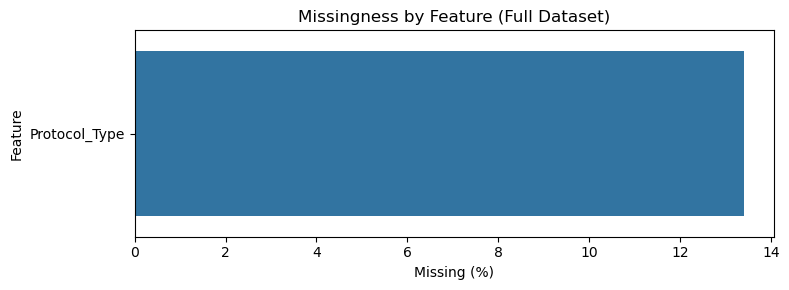

In [10]:
# visualization for missing features
nonzero_missing = missing_df[missing_df["missing_count"] > 0].copy()

if not nonzero_missing.empty:
    plt.figure(figsize=(8, max(3, 0.3 * len(nonzero_missing))))
    sns.barplot(
        data=nonzero_missing,
        y="feature",
        x="missing_pct",
        orient="h"
    )
    plt.xlabel("Missing (%)")
    plt.ylabel("Feature")
    plt.title("Missingness by Feature (Full Dataset)")
    plt.tight_layout()
    plt.show()

Numeric Descriptive Statistics

In [13]:
# establish the numeric columns using Int32 or Float32 data types
numeric_cols = [
    name for name in col_names
    if schema[name] in {pl.Int32, pl.Float32}]

# build aggregate expressions for each numeric column
# intiitalize the empty list
agg_exprs = []

# for loop to append the aggregate expressions for each numeric column
for c in numeric_cols:
    agg_exprs.extend([
        pl.col(c).mean().alias(f"{c}_mean"),
        pl.col(c).std().alias(f"{c}_std"),
        pl.col(c).min().alias(f"{c}_min"),
        pl.col(c).quantile(0.25).alias(f"{c}_q1"),
        pl.col(c).median().alias(f"{c}_median"),
        pl.col(c).quantile(0.75).alias(f"{c}_q3"),
        pl.col(c).max().alias(f"{c}_max"),
    ])

# run a single lazy pass over the full dataset
stats_pl = scan.select(agg_exprs).collect()

# convert to pandas and reshape to a nicer format
stats_df = stats_pl.to_pandas().T
stats_df.columns = ["value"]

# reshape to a wider format
rows = []
for idx, val in stats_df["value"].items():
    feature, stat = idx.rsplit("_", 1)
    rows.append([feature, stat, val])

wide = pd.DataFrame(rows, columns=["feature", "stat", "value"])
wide_df = wide.pivot(index="feature", columns="stat", values="value")

wide_df

stat,max,mean,median,min,q1,q3,std
feature,,,,,,,
ARP,1.000000e+00,0.005679,0.000000,0.000000,0.000000,0.000000,0.027051
AVG,9.430300e+03,207.398041,60.299999,46.000000,60.000000,134.100006,315.032959
DHCP,8.000000e-01,0.000375,0.000000,0.000000,0.000000,0.000000,0.007011
DNS,1.000000e+00,0.005640,0.000000,0.000000,0.000000,0.000000,0.032201
HTTP,1.000000e+00,0.065235,0.000000,0.000000,0.000000,0.000000,0.237366
HTTPS,1.000000e+00,0.096103,0.000000,0.000000,0.000000,0.010000,0.267552
Header_Length,6.000000e+01,14.022944,19.799999,0.000000,7.920000,20.000000,9.085971
IAT,7.861200e+04,0.022037,0.000080,-0.017818,0.000038,0.000225,31.001877
ICMP,1.000000e+00,0.113021,0.000000,0.000000,0.000000,0.000000,0.308100


I note that the above numeric descriptive statistics dataframe is revealing especially identifying that there is a minimum value for the feature IAT of -0.01781797967851162. This says that there are packets which are arriving before the next packet and is not an artifact of actual network traffic. This will have to be readjusted to clamp negative values to zero or left as is. This occurs as a result of packet capture timestamp jitter which is aknown limitation of CICFlowMeter.

Categorical Descriptive Statistics


In [24]:
categorical_cols = ["Protocol_Type", "Label"]

# initialize empty categorical summary dictionary
categorical_summary = {}

# for loop to compute value counts for each categorical column
for col in categorical_cols:
    # Compute full value counts for the column using lazy evaluation
    value_counts_df = (
        scan
        .group_by(col)
        .len()
        .sort("len", descending=True)
        .collect()
        .to_pandas()
        .rename(columns={"len": "count"})
    )
    
    categorical_summary[col] = value_counts_df

# display
display(value_counts_df)
display(categorical_summary["Protocol_Type"])

,Label,count
0,DDOS-UDP_FLOOD,1964164
1,DDOS-ICMP_FLOOD,1907561
2,DOS-UDP_FLOOD,1851682
3,DDOS-SYN_FLOOD,1764599
4,DDOS-PSHACK_FLOOD,1641898
5,DDOS-TCP_FLOOD,1560619
6,DDOS-RSTFINFLOOD,1255787
7,DDOS-SYNONYMOUSIP_FLOOD,1171378
8,DOS-SYN_FLOOD,1138614
9,DOS-TCP_FLOOD,1120182


,Protocol_Type,count
0,MIRAI-UDPPLAIN,11137862
1,DDOS-ACK_FRAGMENTATION,4855847
2,NaN,2814440
3,DDOS-SYNONYMOUSIP_FLOOD,2184554
4,DDOS-PSHACK_FLOOD,12534
5,DDOS-RSTFINFLOOD,3


This above categorical descriptive stats combined with the missing values statistics shows that there are 2,814,440 missing Protocol Types, which is roughly ~14% of the cleaned dataset. We may consider dropping the missing values in order to properly clean our dataset for modeling even further.

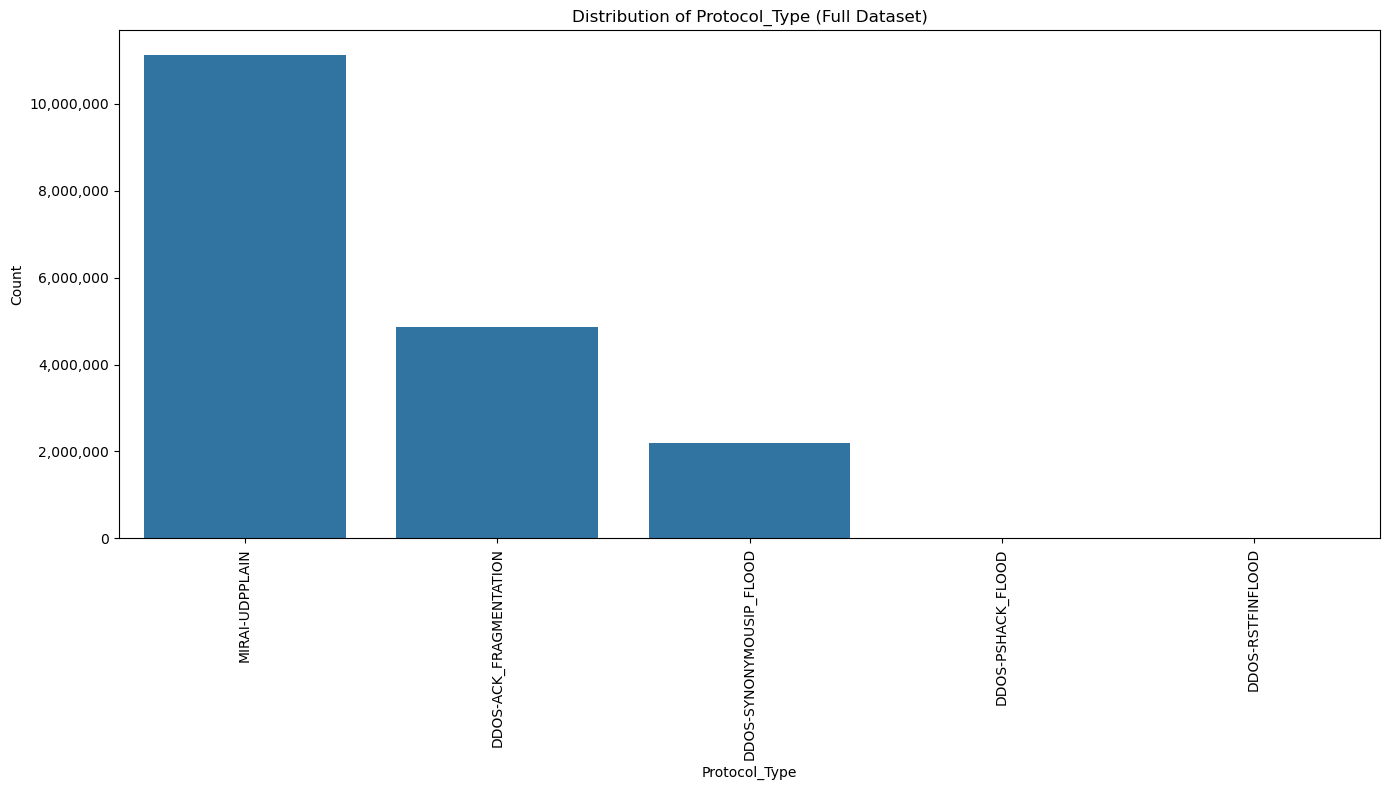

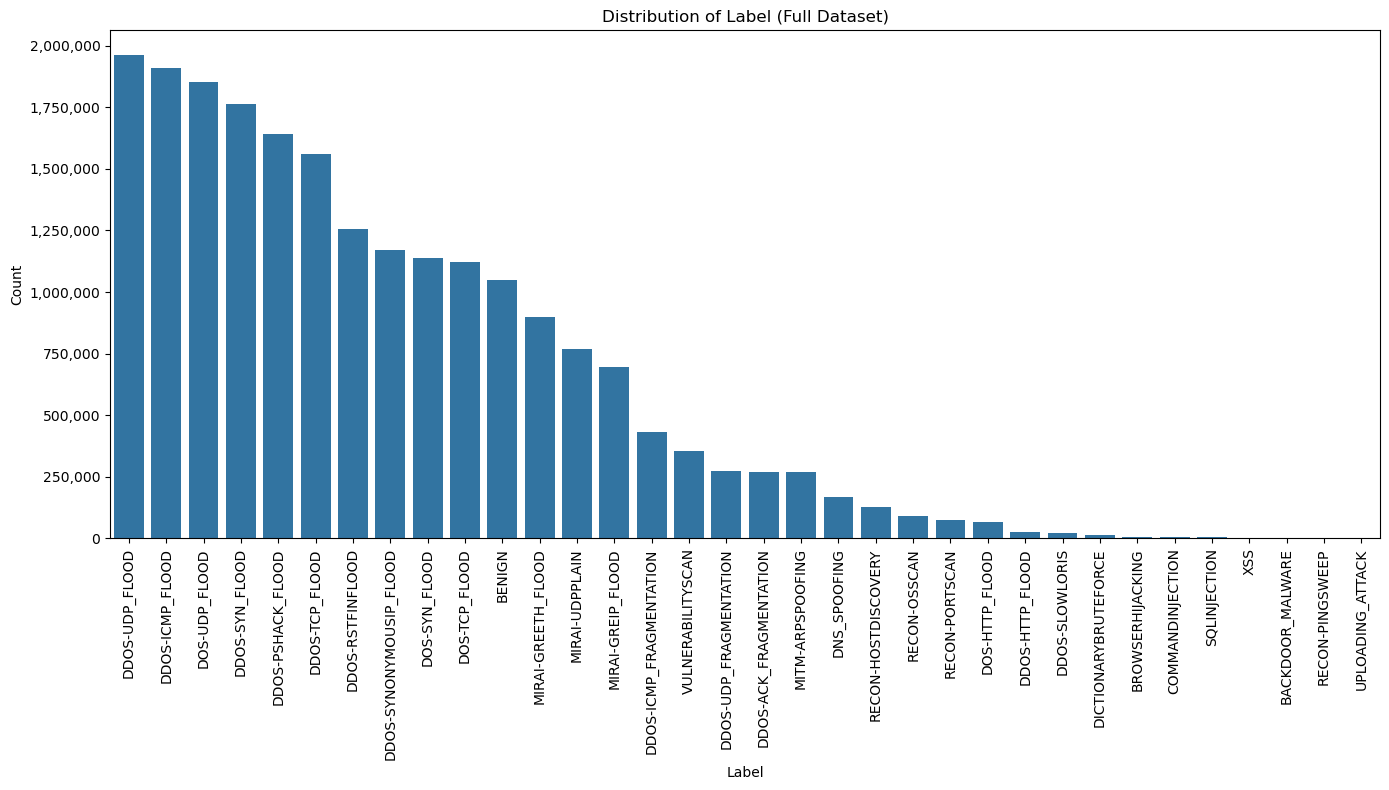

In [23]:
for col in categorical_cols:
    value_counts_df = categorical_summary[col]
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=value_counts_df, x=col, y="count")
    # Rotate x labels vertically for readability
    plt.xticks(rotation=90)
    # Format y-axis with comma separators
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.title(f"Distribution of {col} (Full Dataset)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()